# Import the scVI model

In [1]:
%matplotlib inline

from scvi import scVI

import tensorflow as tf
import numpy as np
import time
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from benchmarking import *

plt.style.use('ggplot')

# Loading and filtering data

In [2]:
X = pd.read_csv("expression.bin", sep="\t", low_memory=False).T
clusters = np.array(X[7], dtype=str)[2:]
_, labels = np.unique(clusters, return_inverse=True)
gene_names = np.array(X.iloc[0], dtype=str)[10:]
X = X.loc[:, 10:]
X = X.drop(X.index[0])
expression_data = np.array(X, dtype=np.int)[1:]

# keep the most variable genes according to the Biscuit ICML paper
selected = np.std(expression_data, axis=0).argsort()[-558:][::-1]
expression_data = expression_data[:, selected]
gene_names = gene_names[selected].astype(str)

#train test split for log-likelihood scores
expression_train, expression_test, c_train, c_test = train_test_split(expression_data, labels)

In [3]:
expression_train.shape

(2253, 558)

# Getting prior for scaling parameters
Get the log library size and its mean and variance

In [4]:
log_library_size = np.log(np.sum(expression_train, axis=1))
mean, var = np.mean(log_library_size), np.var(log_library_size)

# Loading scVI on memory

In [5]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')

model = scVI(x, n_hidden=20)

# Tensorflow session

In [6]:
# Session creation
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Training

In [7]:
batch_size = 100

In [8]:
def next_batch(data, batch_size):
    index = np.random.choice(np.arange(data.shape[0]), size=batch_size)
    return data[index].astype(np.float32)

In [9]:
def train_model(num_epochs, expression_train, expression_test):
    train_loss = []
    valid_loss = []
    
    iterep = int(expression_train.shape[0] / float(batch_size)) - 1  
    
    for t in range(iterep * num_epochs):
        # arrange data in batches
        x_train = next_batch(expression_train, batch_size)
        x_test = next_batch(expression_test, batch_size)

        #prepare data dictionaries
        dic_train = {x: x_train}
        dic_test = {x: expression_test} 
        
        # run an optimization set
        _, l_tr = sess.run([model.train_step, model.loss], feed_dict=dic_train)
        end_epoch, epoch = t % iterep == 0, t / iterep

        if end_epoch:          
            print(epoch)
            l_t = sess.run((model.loss), feed_dict=dic_test)
            
            print('Train / Validation performance:', l_tr, l_t)
            
            if np.isnan(l_tr):
                break
        
            train_loss.append(l_tr)
            valid_loss.append(l_t)
            
    return train_loss, valid_loss

In [10]:
train_loss, valid_loss = train_model(300, expression_train, expression_test)

0.0
Train / Validation performance: 36212.375 36436.49
1.0
Train / Validation performance: 38397.254 35862.508
2.0
Train / Validation performance: 32865.0 33917.223
3.0
Train / Validation performance: 34236.29 32973.68
4.0
Train / Validation performance: 34698.1 32571.844
5.0
Train / Validation performance: 30379.404 32370.605
6.0
Train / Validation performance: 37206.56 32210.846
7.0
Train / Validation performance: 33406.746 32030.79
8.0
Train / Validation performance: 29659.805 31927.684
9.0
Train / Validation performance: 34654.695 31744.201
10.0
Train / Validation performance: 34538.41 31618.428
11.0
Train / Validation performance: 30756.484 31489.336
12.0
Train / Validation performance: 29192.6 31357.186
13.0
Train / Validation performance: 26991.064 31234.191
14.0
Train / Validation performance: 33016.92 31093.652
15.0
Train / Validation performance: 35259.234 30968.707
16.0
Train / Validation performance: 33083.227 30840.549
17.0
Train / Validation performance: 35246.426 30726.5

145.0
Train / Validation performance: 16308.202 16814.371
146.0
Train / Validation performance: 17408.281 16713.477
147.0
Train / Validation performance: 15592.432 16630.736
148.0
Train / Validation performance: 16516.85 16564.201
149.0
Train / Validation performance: 17024.346 16495.662
150.0
Train / Validation performance: 14804.25 16405.14
151.0
Train / Validation performance: 18586.463 16290.887
152.0
Train / Validation performance: 15556.161 16239.966
153.0
Train / Validation performance: 14960.89 16109.192
154.0
Train / Validation performance: 17492.998 16028.276
155.0
Train / Validation performance: 18614.902 15954.051
156.0
Train / Validation performance: 15913.202 15860.076
157.0
Train / Validation performance: 14515.428 15781.764
158.0
Train / Validation performance: 17211.34 15682.356
159.0
Train / Validation performance: 15122.155 15598.668
160.0
Train / Validation performance: 15345.251 15522.19
161.0
Train / Validation performance: 16338.798 15441.51
162.0
Train / Validat

289.0
Train / Validation performance: 7901.59 7544.5225
290.0
Train / Validation performance: 7813.971 7500.228
291.0
Train / Validation performance: 7293.8623 7465.746
292.0
Train / Validation performance: 7729.2036 7423.46
293.0
Train / Validation performance: 7439.5713 7403.1304
294.0
Train / Validation performance: 7649.6133 7361.4854
295.0
Train / Validation performance: 8041.821 7317.0264
296.0
Train / Validation performance: 6925.5312 7298.1016
297.0
Train / Validation performance: 6878.3936 7249.2236
298.0
Train / Validation performance: 7745.371 7217.3247
299.0
Train / Validation performance: 7578.082 7177.133


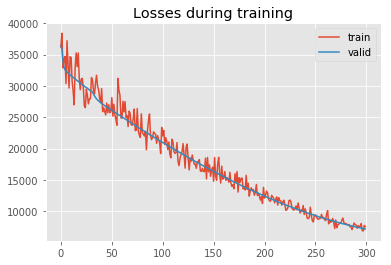

In [11]:
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend()
plt.title('Losses during training')
plt.show()

# Clustering

We can here sample fron the latent space, you can verify that the clustering metrics are robust with respect to different samples from the variational posterior

In [12]:
# Encode the data
latent = sess.run(model.z, feed_dict={x: expression_train})
pca_latent = PCA(n_components=2).fit_transform(expression_train)

In [13]:
# Evaluate clusters in latent space: the higher the silhouette, the 
# better the classes are separated
lat_silh = silhouette_score(latent, c_train)
pca_silh = silhouette_score(pca_latent, c_train)

scores = {'scVI': lat_silh, 'PCA': pca_silh}
max_key = max(scores, key=scores.get)

print('Silhouette scores (higher is better):')
for key in scores:
    if key == max_key: print('\033[1m', end="")
    print('- ' + key + ': %0.3f' % scores[key] + '\033[0m')

Silhouette scores (higher is better):
- scVI: 0.236
- PCA: -0.206


# Visualization

Our latent space is low-dimensional and therefore tSNE friendly !

In [14]:
def show_latent(latent, labels):
    plt.figure(figsize=(10, 10))

    if latent.shape[1] > 2:
        latent = TSNE().fit_transform(latent)
        plt.axis("off") # axis don't matter for a t-SNE plot
        
    plt.scatter(latent[:, 0], latent[:, 1], c=labels,
                    cmap=plt.get_cmap("tab10", 7), edgecolors='none', s=30, alpha=0.7)
    plt.axis('equal')
    plt.title("Latent space for scVI")

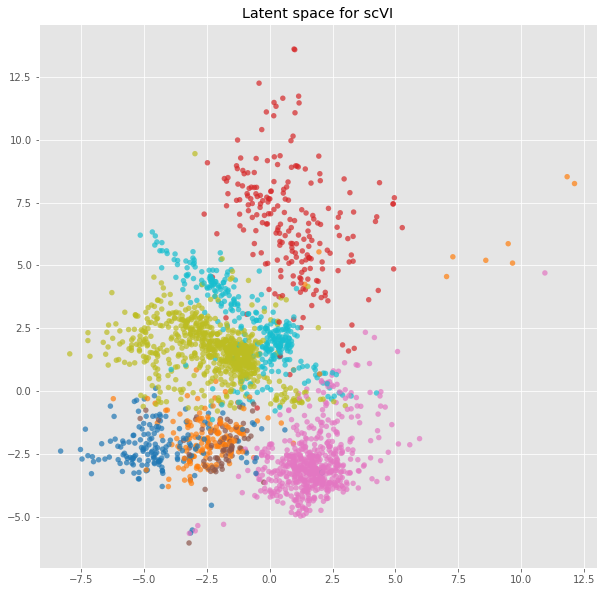

In [15]:
show_latent(latent, c_train)

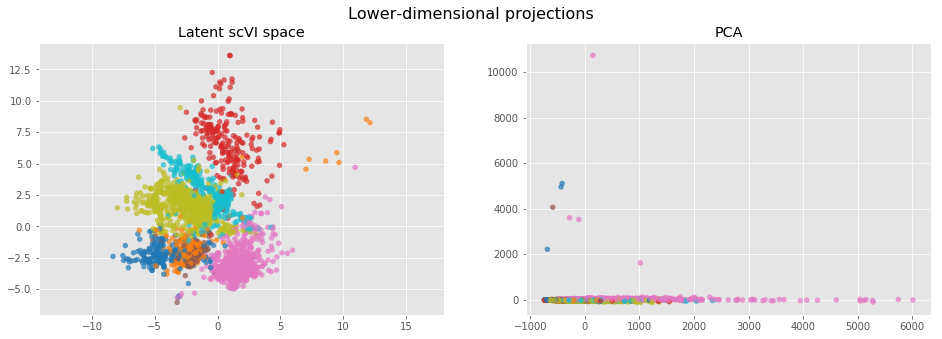

In [16]:
s=30 
alpha=0.7

fig = plt.figure(figsize=(16,5))
plt.suptitle('Lower-dimensional projections', fontsize=16)

plt.subplot(1, 2, 1)
plt.axis('equal')
if latent.shape[1] > 2:
    latent = TSNE().fit_transform(latent)
    plt.axis("off") # axis don't matter for a t-SNE plot
plt.scatter(latent[:, 0], latent[:, 1], c=c_train,
                    cmap=plt.get_cmap("tab10", 7), edgecolors='none', s=s, alpha=alpha)
plt.title('Latent scVI space')

plt.subplot(1, 2, 2)
plt.scatter(pca_latent[:, 0], pca_latent[:, 1], c=c_train,
                    cmap=plt.get_cmap("tab10", 7), edgecolors='none', s=s, alpha=alpha)
plt.title('PCA')

plt.show()

# Imputation

We now turn to the imputation result. For that, we need to recomplete scVI's inference on corrupted data. That means clearing the computation graph of TensorFlow and starting with a new one. We corrupt the data by uniform sampling over the non-zero entries (10%)

In [17]:
# Corrupt the data with zeros at known positions according to ZIFA
X_zero, i, j, ix = dropout(expression_train, decay=0.2)

In [18]:
print('Zero proportion in original data set:')
print(1 - np.count_nonzero(expression_train) / expression_train.size)

Zero proportion in original data set:
0.28890352488995164


In [19]:
print('Zero proportion in corrupted data set:')
print(1 - np.count_nonzero(X_zero) / X_zero.size)

Zero proportion in corrupted data set:
0.3600130133139884


In [20]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')

model = scVI(x, n_hidden=15)

# Session creation
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [21]:
train_loss, valid_loss = train_model(100, X_zero, expression_test)

0.0
Train / Validation performance: 29294.285 35711.367
1.0
Train / Validation performance: 31177.51 35405.797
2.0
Train / Validation performance: 27449.932 33908.16
3.0
Train / Validation performance: 28198.807 32353.617
4.0
Train / Validation performance: 29839.105 31915.73
5.0
Train / Validation performance: 30838.994 31773.207
6.0
Train / Validation performance: 27949.602 31802.896
7.0
Train / Validation performance: 29691.074 31448.664
8.0
Train / Validation performance: 29426.63 31273.654
9.0
Train / Validation performance: 27701.387 31125.434
10.0
Train / Validation performance: 25417.512 30969.514
11.0
Train / Validation performance: 28265.215 30899.486
12.0
Train / Validation performance: 30988.72 30731.148
13.0
Train / Validation performance: 29250.975 30602.76
14.0
Train / Validation performance: 25285.06 30455.486
15.0
Train / Validation performance: 30168.46 30393.605
16.0
Train / Validation performance: 28712.29 30216.402
17.0
Train / Validation performance: 27344.252 301

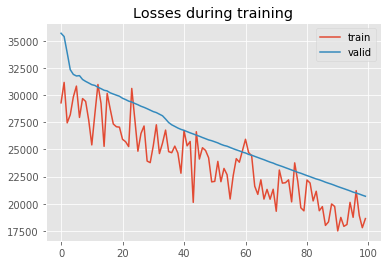

In [22]:
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend()
plt.title('Losses during training')
plt.show()

In [23]:
# Get Poisson means for zeroed out points
rate_ = sess.run(model.px_rate, {x: X_zero} )

# Compute the imputation error at zeroed out points
imputation_error(rate_, expression_train, X_zero, i, j, ix)

6.997849214589223